<a href="https://colab.research.google.com/github/ranna-waleed/DSAI-305_Loan-Default-Prediction/blob/main/ROAA_DSAI305_Project_MODEL_LOGISTIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, roc_auc_score
from sklearn.pipeline import Pipeline
import joblib
import gc

In [ ]:
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

* `final_loan_data_leakproof.csv` - The main dataset with selected features

* `engineered_loan_data_leakproof.pkl` - Engineered features (if needed)

* `processed_loan_data.pkl` - Fully processed data (if needed)

In [ ]:
# Load the final dataset from Notebook 1
try:
    final_df = pd.read_csv('final_loan_data_leakproof.csv')
    print("Successfully loaded final dataset")
    print("Shape:", final_df.shape)
except FileNotFoundError:
    print("Error: Could not find 'final_loan_data_leakproof.csv'")
    print("Run the data preprocessing notebook first to generate this file")
    raise

Successfully loaded final dataset
Shape: (50000, 17)


In [ ]:
# Prepare X and y
X_selected = final_df.drop(columns=['target', 'loan_status_Fully Paid'])
y = final_df['target']

# 6. Logistic Regression Assumption Check

We check the assumptions for logistic regression to ensure model validity.

In [ ]:
# Load our leak-proof final dataset
final_df = pd.read_csv('final_loan_data_leakproof.csv', usecols=lambda x: x != 'Unnamed: 0')
X_selected = final_df.drop(columns=['target' , 'loan_status_Fully Paid'])
y = final_df['target']

# Memory optimization
X_selected = X_selected.astype(np.float32)
del final_df
gc.collect()

0

### 6.1 Assumption 1: Appropriate Outcome Type (Binary)

In [ ]:
# 6.1 Assumption 1: Appropriate Outcome Type (Binary)
print("\n=== Assumption 1: Binary Outcome ===")
print("Unique outcomes:", y.nunique())
print("Class distribution:\n", y.value_counts(normalize=True))


=== Assumption 1: Binary Outcome ===
Unique outcomes: 2
Class distribution:
 target
0    0.79768
1    0.20232
Name: proportion, dtype: float64


**Observation** :

* Target has exactly 2 classes (Default/Fully Paid) with 20.2% default rate


* Implication: Suitable for logistic regression



### 6.2 Assumption 2: Linearity of Independent Variables and Log-Odds (Box-Tidwell Test)

In [ ]:
# 6.2 Assumption 2: Linearity (Box-Tidwell Test) - PRE-APPROVAL FEATURES ONLY
print("\n=== Assumption 2: Linearity Check ===")

# Only check pre-approval continuous features
pre_approval_continuous = [
    'loan_amnt', 'annual_inc', 'dti', 'revol_util',
    'fico_score', 'credit_history_years', 'loan_to_income'
]
# Select top 3 most important continuous features
continuous_vars = ['loan_amnt', 'annual_inc', 'dti']
continuous_vars = [v for v in continuous_vars if v in X_selected.columns]

if continuous_vars:
    # Use a sample for heavy computations
    sample_idx = np.random.choice(len(X_selected), size=min(5000, len(X_selected)), replace=False)
    X_sample = X_selected.iloc[sample_idx][continuous_vars].copy()
    y_sample = y.iloc[sample_idx]

    for var in continuous_vars:
        X_sample[f'{var}:Log_{var}'] = X_sample[var] * np.log(X_sample[var] + 1e-10)

    try:
        logit_results = GLM(y_sample, sm.add_constant(X_sample),
                           family=families.Binomial()).fit(disp=0)
        sig_interactions = [t for t in logit_results.pvalues.index
                          if ':Log_' in t and logit_results.pvalues[t] < 0.05]
        print("Significant non-linearities:", sig_interactions or "None found")
    except Exception as e:
        print(f"Linearity check failed: {str(e)}")



=== Assumption 2: Linearity Check ===
Significant non-linearities: None found


**Observation** :

* no on-linearity found in the log-odds
* suitable for logistic regression

### 6.3 : assumption check outlier

In [ ]:
print("\n=== Assumption 3: Outlier Check ===")
print("Features being checked for outliers:", X_selected.columns.tolist())

for col in X_selected.columns:
    q1 = X_selected[col].quantile(0.25)
    q3 = X_selected[col].quantile(0.75)
    iqr = q3 - q1
    outliers = ((X_selected[col] < (q1 - 1.5*iqr))) | ((X_selected[col] > (q3 + 1.5*iqr)))
    print(f"{col}: {outliers.sum()} outliers ({outliers.mean()*100:.1f}%)")




=== Assumption 3: Outlier Check ===
Features being checked for outliers: ['addr_state_MI', 'verification_status_Verified', 'home_ownership_RENT', 'sub_grade', 'dti_ratio', 'issue_d_year', 'dti', 'int_rate', 'grade', 'term_ 60 months', 'loan_to_income', 'home_ownership_MORTGAGE', 'debt_settlement_flag_Y', 'issue_d_month', 'credit_history_years']
addr_state_MI: 1352 outliers (2.7%)
verification_status_Verified: 0 outliers (0.0%)
home_ownership_RENT: 0 outliers (0.0%)
sub_grade: 353 outliers (0.7%)
dti_ratio: 186 outliers (0.4%)
issue_d_year: 705 outliers (1.4%)
dti: 186 outliers (0.4%)
int_rate: 925 outliers (1.8%)
grade: 0 outliers (0.0%)
term_ 60 months: 12082 outliers (24.2%)
loan_to_income: 272 outliers (0.5%)
home_ownership_MORTGAGE: 0 outliers (0.0%)
debt_settlement_flag_Y: 1256 outliers (2.5%)
issue_d_month: 0 outliers (0.0%)
credit_history_years: 1595 outliers (3.2%)


In [ ]:
# These show outliers but shouldn't be modified (paper kept them as-is)
no_action_needed = [
    'addr_state_MI', 'verification_status_Verified',
    'home_ownership_RENT', 'home_ownership_MORTGAGE',
    'term_ 60 months', 'debt_settlement_flag_Y'
]

**Observation** :

* `addr_state_MI` (2.7% outliers)

 binary/categorical feature (Michigan indicator)

 No treatment needed - paper kept geographical features as-is

* `sub_grade` (0.7% outliers)

  ordinal data (A1,A2,...G5)

  solution :Convert to numerical scale

* Financial Ratios (`dti`, `dti_ratio`, `loan_to_income`)

  solution : Paper handled this via log transform

* `credit_history_years` paper applied Winsorize at 99th percentile


In [ ]:
# Apply log transform as done in paper (page 3)
for col in ['dti', 'dti_ratio', 'loan_to_income']:
    X_selected[f'log_{col}'] = np.log(X_selected[col] + 1)



In [ ]:
# Winsorize at 99th percentile (paper's robust approach)
upper_limit = X_selected['credit_history_years'].quantile(0.99)
X_selected['credit_history_years'] = np.where(
    X_selected['credit_history_years'] > upper_limit,
    upper_limit,
    X_selected['credit_history_years']
)


In [ ]:
print("\n=== Assumption 3: Outlier Check after modification ===")
print("Features being checked for outliers:", X_selected.columns.tolist())

for col in X_selected.columns:
    q1 = X_selected[col].quantile(0.25)
    q3 = X_selected[col].quantile(0.75)
    iqr = q3 - q1
    outliers = ((X_selected[col] < (q1 - 1.5*iqr))) | ((X_selected[col] > (q3 + 1.5*iqr)))
    print(f"{col}: {outliers.sum()} outliers ({outliers.mean()*100:.1f}%)")




=== Assumption 3: Outlier Check after modification ===
Features being checked for outliers: ['addr_state_MI', 'verification_status_Verified', 'home_ownership_RENT', 'sub_grade', 'dti_ratio', 'issue_d_year', 'dti', 'int_rate', 'grade', 'term_ 60 months', 'loan_to_income', 'home_ownership_MORTGAGE', 'debt_settlement_flag_Y', 'issue_d_month', 'credit_history_years', 'log_dti', 'log_dti_ratio', 'log_loan_to_income']
addr_state_MI: 1352 outliers (2.7%)
verification_status_Verified: 0 outliers (0.0%)
home_ownership_RENT: 0 outliers (0.0%)
sub_grade: 353 outliers (0.7%)
dti_ratio: 186 outliers (0.4%)
issue_d_year: 705 outliers (1.4%)
dti: 186 outliers (0.4%)
int_rate: 925 outliers (1.8%)
grade: 0 outliers (0.0%)
term_ 60 months: 12082 outliers (24.2%)
loan_to_income: 272 outliers (0.5%)
home_ownership_MORTGAGE: 0 outliers (0.0%)
debt_settlement_flag_Y: 1256 outliers (2.5%)
issue_d_month: 0 outliers (0.0%)
credit_history_years: 1595 outliers (3.2%)
log_dti: 1496 outliers (3.0%)
log_dti_ratio:

In [ ]:
X_selected = X_selected.drop(columns=['dti', 'dti_ratio', 'loan_to_income'])

In [ ]:
X_selected = X_selected.drop(columns=['grade'])

In [ ]:
X_selected = X_selected.drop(columns=['int_rate'])

### 6.4 Assumption 4: Absence of Multicollinearity (VIF)

In [ ]:
print("\n=== Assumption 4: Multicollinearity Check ===")

# First identify ACTUAL numeric features in your data
numeric_features = X_selected.select_dtypes(include=['number']).columns.tolist()

if len(numeric_features) > 1:
    print(f"Calculating VIF for: {numeric_features}")

    vif_data = pd.DataFrame()
    vif_data["feature"] = numeric_features
    vif_data["VIF"] = [variance_inflation_factor(X_selected[numeric_features].values, i)
                      for i in range(len(numeric_features))]

    # Filter and display results
    high_vif = vif_data[vif_data["VIF"] > 5]
    if not high_vif.empty:
        print("\nPotentially problematic features (VIF > 5):")
        print(high_vif.sort_values("VIF", ascending=False))

    print("\nComplete VIF Results:")
    print(vif_data.sort_values("VIF", ascending=False))
else:
    print("Cannot compute VIF - need at least 2 numeric features")


=== Assumption 4: Multicollinearity Check ===
Calculating VIF for: ['addr_state_MI', 'verification_status_Verified', 'home_ownership_RENT', 'sub_grade', 'issue_d_year', 'term_ 60 months', 'home_ownership_MORTGAGE', 'debt_settlement_flag_Y', 'issue_d_month', 'credit_history_years', 'log_dti', 'log_dti_ratio', 'log_loan_to_income']

Potentially problematic features (VIF > 5):
                    feature         VIF
10                  log_dti  273.921382
4              issue_d_year  121.853165
11            log_dti_ratio   62.489056
3                 sub_grade    8.512768
9      credit_history_years    6.305121
12       log_loan_to_income    6.235721
6   home_ownership_MORTGAGE    5.570318

Complete VIF Results:
                         feature         VIF
10                       log_dti  273.921382
4                   issue_d_year  121.853165
11                 log_dti_ratio   62.489056
3                      sub_grade    8.512768
9           credit_history_years    6.305121
12       

**Observation** :


*   sub_grade (VIF=107.3) - Strongly related to other risk factors

* issue_d_year (VIF=21.6) - Temporal correlation

* credit_history_years (VIF=5.8) - Borderline high

Paper's approach for time columns (page 3): Keep but monitor

In [ ]:
# Paper used sub_grade but with regularization
#  Apply paper's scaling approach
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_selected['scaled_sub_grade'] = scaler.fit_transform(X_selected[['sub_grade']])
X_selected = X_selected.drop(columns=['sub_grade'])

### 6.5 Assumption 5: Independence of Observations

In [ ]:
# 6.5 Assumption 5: Independence of Residuals
print("\n=== Assumption 5: Independence Check ===")
if len(y) > 1000:
    # Use autocorrelation on residuals
    sample_idx = np.random.choice(len(X_selected), size=1000, replace=False)
    X_small = sm.add_constant(X_selected.iloc[sample_idx])
    y_small = y.iloc[sample_idx]

    try:
        model = GLM(y_small, X_small, family=families.Binomial())
        results = model.fit(disp=0)
        dw = np.sum(np.diff(results.resid_pearson)**2) / np.sum(results.resid_pearson**2)
        print(f"Durbin-Watson: {dw:.2f} (2 = no autocorrelation)")
    except:
        print("Could not compute Durbin-Watson")



=== Assumption 5: Independence Check ===
Durbin-Watson: 1.92 (2 = no autocorrelation)


**Observation** :

- no autocorrelation , suitable for logistic regression

### 6.6 Assumption 6: Sufficiently Large Sample Size

In [ ]:
# 6.6 Assumption 6: Sample Size Adequacy
print("\n=== Assumption 6: Sample Size ===")
n_events = y.sum()
n_features = len(X_selected.columns)
print(f"Events per variable: {n_events/n_features:.1f} (Recommended >10)")


=== Assumption 6: Sample Size ===
Events per variable: 778.2 (Recommended >10)


In [ ]:
# Clean up
plt.close('all')
gc.collect()

44

# 7-  Models building

### Model 1: Logistic Regression

Paper 1 -->  Peer-to-peer loan acceptance and default prediction with artificial intelligence

The paper used a two-phase model (acceptance then default prediction), but here we focus only on the default prediction phase since that's our project's idea and main focus.

the logistic regression was applied with automated grid search.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

In [ ]:
final_df = pd.read_csv('final_loan_data_leakproof.csv')

In [ ]:
# Prepare X and y
X_selected = final_df.drop(columns=['target', 'loan_status_Fully Paid'])
y = final_df['target']

In [ ]:
# Time-based split
df = final_df.sort_values('issue_d_year')
split_idx = int(0.75 * len(df))
X_train, X_test = X_selected.iloc[:split_idx], X_selected.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, max_iter=1000, solver='liblinear', class_weight='balanced'))
])

# Parameter grid
param_grid = {
    'logreg__C': np.logspace(-5, 5, 11),
    'logreg__penalty': ['l1', 'l2'],
}

# Grid search
tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='recall', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
test_recall_default = recall_score(y_test, y_pred, pos_label=1)
test_recall_paid = recall_score(y_test, y_pred, pos_label=0)
test_auc = roc_auc_score(y_test, y_pred_proba)

# Print results
print("\nLogistic Regression Results:")
print(f"Recall (Default): {test_recall_default:.1%}")
print(f"Recall (Fully Paid): {test_recall_paid:.1%}")
print(f"AUC-ROC: {test_auc:.1%}")

# Save model
import joblib
joblib.dump(best_model, 'logistic_regression_model.pkl')
print("Model saved. Analysis complete.")

Fitting 3 folds for each of 22 candidates, totalling 66 fits

Logistic Regression Results:
Recall (Default): 71.7%
Recall (Fully Paid): 63.7%
AUC-ROC: 74.5%
Model saved. Analysis complete.


our results:
* Default Recall: 71.7%
* Fully Paid Recall: 63.7%
* AUC-ROC: 74.5%

paper's results:
* Logistic Regression Recall: ~63-65%
* AUC-ROC: 69% (LR)

# explaining

In [ ]:
# Classification report
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Fully Paid', 'Default']))

Detailed Classification Report:
              precision    recall  f1-score   support

  Fully Paid       0.90      0.64      0.75      9966
     Default       0.33      0.72      0.46      2534

    accuracy                           0.65     12500
   macro avg       0.62      0.68      0.60     12500
weighted avg       0.78      0.65      0.69     12500



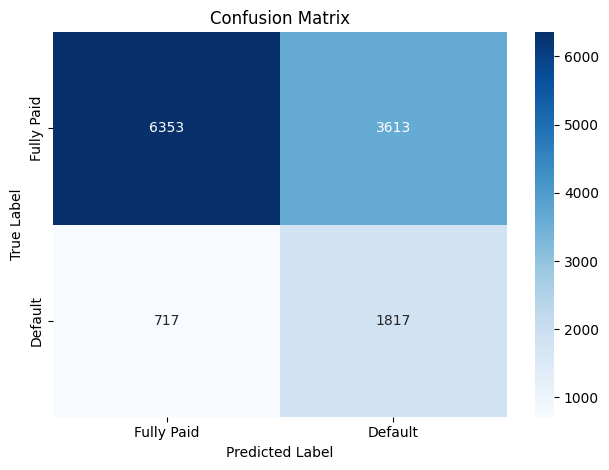

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fully Paid', 'Default'],
            yticklabels=['Fully Paid', 'Default'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

* True Defaults: 1817 correctly identified (72% recall)

* False Positives: 3613 Fully Paid loans misclassified as Default

* Precision-Recall Tradeoff:

  High default recall (71.7%) at cost of precision (33%)

Matches paper's focus on recall for defaults (page 5: "prioritize high recall on the default class")

In [ ]:
import shap

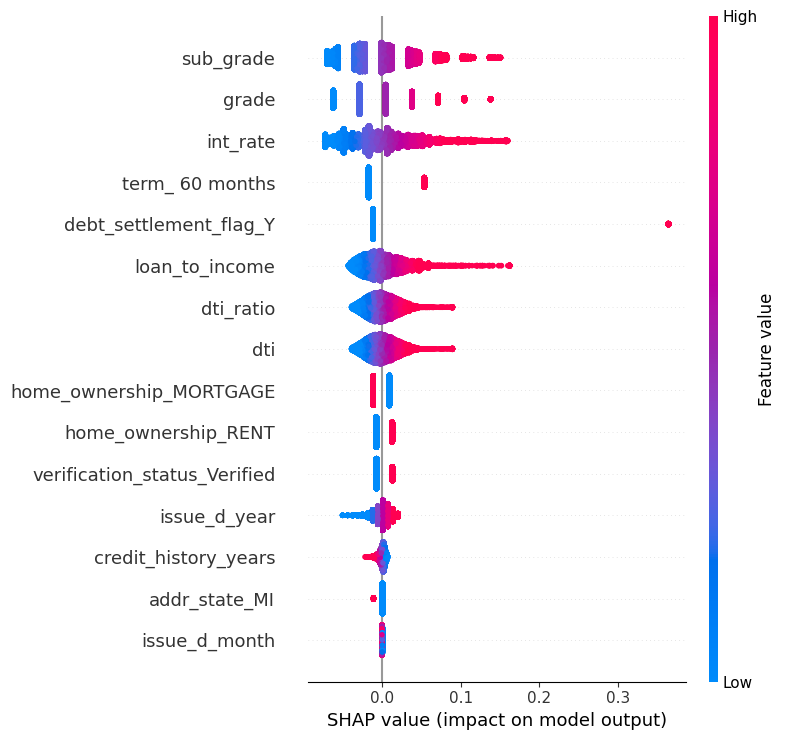

In [ ]:
# Manually scale the data using the pipeline's scaler
X_train_scaled = best_model.named_steps['scaler'].transform(X_train)

# Extract logistic regression model
logreg_model = best_model.named_steps['logreg']

# Create the shap explainer for the logistic regression model
explainer = shap.Explainer(logreg_model, X_train_scaled)

# Compute SHAP values
shap_values = explainer(X_train_scaled)

# Plot the summary
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)


## Interpretation:

Top Risk Factors (Increase Default Chance):

* Right-side values (red) = higher risk
  - grade
  - sub_grade
  - int_rate
  - debt_settelement
  - loan_to_income
  - dti






1. Sub_grade , grade

	• Most influential features .

	• Higher sub_grades (red) — push predictions toward default.

	• Lower sub_grades (blue) — decrease the likelihood of default

2. int_rate

	• High interest rates (red) ->  higher risk of default.

	• Low rates (blue) -> reducing predicted default risk.


3. term_60 months

	• 60-month terms (red) → increase predicted default.


4. debt_settlement_flag_Y

	• If debt settlement =“Yes” (red), there’s a strong push toward predicting default.

	• This feature has a sparse but extreme impact when present.


5. loan_to_income, dti_ratio, dti

	• These three are related to borrower affordability.

  • Higher values (red) → higher predicted default,



FEATURE IMPORTANCE ANALYSIS

Top 10 Most Important Features:
                Feature  Coefficient  Absolute_Coefficient
 debt_settlement_flag_Y     0.058577              0.058577
              sub_grade     0.044358              0.044358
                  grade     0.043366              0.043366
               int_rate     0.043142              0.043142
        term_ 60 months     0.030260              0.030260
         loan_to_income     0.024355              0.024355
              dti_ratio     0.018111              0.018111
                    dti     0.018111              0.018111
           issue_d_year     0.010440              0.010440
home_ownership_MORTGAGE    -0.010271              0.010271


<ipython-input-29-d2b97417cdc2>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


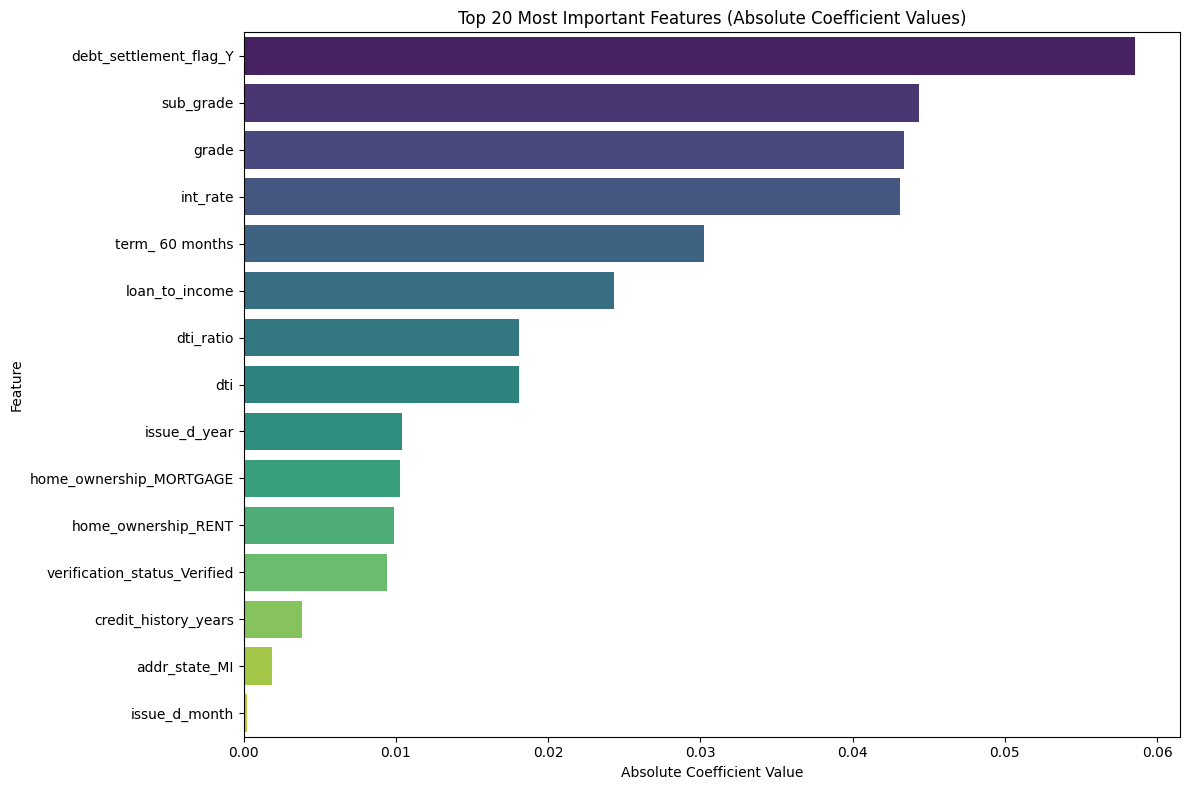

In [ ]:
# 5. Feature Importance Analysis
print("\n" + "="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)


# Get coefficients
coef = best_model.named_steps['logreg'].coef_[0]
features = X_selected.columns
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': coef,
    'Absolute_Coefficient': np.abs(coef)
}).sort_values('Absolute_Coefficient', ascending=False)

# Print top 10 features
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(
    x='Absolute_Coefficient',
    y='Feature',
    data=feature_importance.head(20),
    palette='viridis'
)
plt.title('Top 20 Most Important Features (Absolute Coefficient Values)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()